In [3]:
from ase.io import read
import numpy as np
import os
from tqdm.auto import tqdm

from matplotlib import pyplot as plt

import sys
#sys.path.append('/Users/rca/Google Drive/My Drive/Cersonsky/Masters/Maria Pakhnova/molecular_crystals/project_folder/')
#from scripts.plotting import *

In [2]:
from ase.visualize.plot import plot_atoms
import numpy as np
from sklearn.decomposition import PCA
from ase.data.colors import jmol_colors

jmol_colors[16] = [253 / 256.0, 231 / 256.0, 76 / 256.0]

def plot_mol(
    mol,
    highlight=None,
    my_colors=None,
    ax=None,
    show_unit_cell=False,
    center_unit_cell=True,
    wrap_frame=True,
    background_alpha=0.3,
    alt_center=None,
    **plot_params,
):

    if alt_center is not None and len(alt_center) > 1:
        fit_pos = mol.positions[alt_center]
        center = np.mean(mol.positions[alt_center], axis=0)
    elif highlight is not None and len(highlight) > 1:
        fit_pos = mol.positions[highlight]
        center = np.mean(mol.positions[highlight], axis=0)
    else:
        fit_pos = mol.positions.copy()
        center = np.mean(mol.positions, axis=0)

    fit_pos -= center
    temp = mol.copy()
    pca_pos = np.zeros((len(mol.positions), 3))
    uncenter = np.zeros((3))

    try:
        pca = PCA(n_components=3).fit(fit_pos)
        pca_pos = pca.transform(mol.positions - center)
        uncenter = pca.transform([center]).flatten()
        if center_unit_cell:
            temp.cell = pca.transform(temp.cell[:])
    except ValueError:
        try:
            pca = PCA(n_components=2).fit(fit_pos)
            pca_pos[:, :2] = pca.transform(mol.positions - center)
            uncenter[:2] = pca.transform([center]).flatten()
            if center_unit_cell:
                temp.cell[:, :2] = pca.transform(temp.cell[:])
        except ValueError:
            pca = PCA(n_components=1).fit(fit_pos)
            pca_pos[:, :1] = pca.transform(mol.positions - center)
            uncenter[:1] = pca.transform([center]).flatten()
            if center_unit_cell:
                temp.cell[:, :1] = pca.transform(temp.cell[:])

    temp.positions = pca_pos + uncenter
    if wrap_frame:
        temp.wrap(eps=1e-10)

    if my_colors is None:
        my_colors = np.array(
            [
                [
                    *jmol_colors[n],
                    1.0 if highlight is None or i in highlight else background_alpha,
                ]
                for i, n in enumerate(mol.numbers)
            ]
        )
    elif highlight is not None:
        my_colors = np.array(
            [
                [
                    *c[:3],
                    1.0 if highlight is None or i in highlight else background_alpha,
                ]
                for i, c in enumerate(my_colors)
            ]
        )
    else:
        my_colors = np.array(my_colors)

    plot_atoms(
            temp,
            ax=ax,
            show_unit_cell=show_unit_cell,
            colors=my_colors,
            **plot_params,
        )

In [4]:
frames = np.asarray(read('ice_w_props.xyz', ':'), dtype=object)
for frame in frames:
    frame.wrap(eps=1E-10)

energies = np.array([frame.info['energy [eV/H2O]'] for frame in frames])

In [5]:
poly_names = [frame.info['name'] for frame in frames]
labels = [frame.info['label'] for frame in frames]
highlighted = [
    i for i, v in enumerate(poly_names)
    if v != labels[i] or v in [0,
        'I', 'II','III','IV','V','VI','VII','VIII','IX','X',
        'XI', 'XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX','XX',
        'CS-I', 'CS-II',  'HS-III', 'IRR', 'IWV',
    ]
]
len(highlighted)

52

In [6]:
frame = frames[highlighted[1]]
frame.info

{'name': 'Ic_I41md',
 'density [g/cm3]': 1.189831,
 'energy [eV/H2O]': -473.574853,
 'edr [eV/H2O]': 0.0,
 'label': 'Ic'}

In [7]:
from PIL import Image, ImageDraw
def crop(img_fn, out_fn):
    img=Image.open(img_fn).convert("RGB")
    npImage=np.array(img)
    h, w=img.size

    # Create same size alpha layer with circle
    alpha = Image.new('L', img.size,0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice([0.025,0.025,h-0.025,w-0.025],0,360,fill=255)

    # Convert alpha Image to numpy array
    npAlpha=np.array(alpha)

    # Add alpha layer to RGB
    npImage=np.dstack((npImage,npAlpha))

    # Save with alpha
    Image.fromarray(npImage).save(out_fn)

/tmp/ipykernel_2423301/4118353129.py:118: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "background" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('raw.svg',bbox_inches='tight', dpi=600, pad_inches=0, background='white')


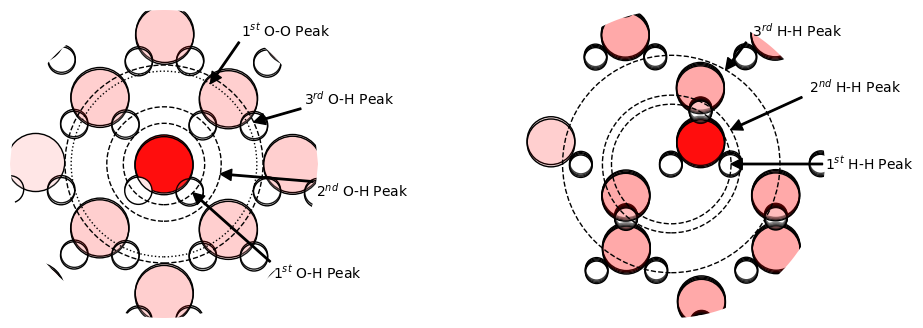

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if True:
    c = np.array([7.4390631757464165, 6.92])
    p = plot_mol(
        frame.repeat(2),
        [16, 24, 73], #42, 90, 115, 23, 73, 99, 106, 2, 11, 37, 124, 85, 172],
        alt_center=[16, 24, 73],
        ax=axes[0],
        rotation='45y',
        background_alpha=0.1,
    )

    border_r = 3.5
    for r, n, col, ang in zip([
            0.925,
            1.3,
            2.25,
            2.11], [
            r'$1^{{st}}$ O-H Peak', r'$2^{{nd}}$ O-H Peak', r'$3^{{rd}}$ O-H Peak',
            r'$1^{{st}}$ O-O Peak'], 'kkkk', np.linspace(-np.pi / 4., np.pi / 3., 4)):
        axes[0].add_artist(
            plt.Circle(
                c,
                r,
                linewidth=1,
                zorder=3,
                fill=None,
                color=col,
                linestyle='dashed' if 'O-H' in n else 'dotted',
                #                    label=n
            ))
        axes[0].annotate(
            xy=c + [r * np.cos(ang), r * np.sin(ang)],
            xytext=c + [border_r * np.cos(ang), border_r * np.sin(ang)],
            text=n,
            zorder=4,
            arrowprops=dict(width=1, color=col, headwidth=8, headlength=8),
            ha='left',
            va='center',
        )

    border = lambda x, neg=1: neg * np.sqrt(border_r**2.0 - (x - c[0])**2.0) + c[1]

    xb = np.linspace(c[0] - border_r, c[0] + border_r, 100)
    axes[0].fill_between(xb, [max(c[1], border(x)) for x in xb],
                         (c[1] +border_r) * np.ones(xb.shape),
                         fc='w',
                         zorder=3,
                         clip_on=True)
    axes[0].fill_between(xb, (c[1] - border_r) * np.ones(xb.shape),
                         [min(c[1], border(x, -1)) for x in xb],
                         fc='w',
                         zorder=3,
                         clip_on=True)

    axes[0].set_xlim([c[0] - border_r, c[0] + border_r])
    axes[0].set_ylim([c[1] - border_r, c[1] + border_r])
    axes[0].axis('off')

p = plot_mol(
    frame.repeat(2),
    [16, 24, 73],
    alt_center=[16, 24, 73],
    ax=axes[1],
    rotation='0y',
    background_alpha=0.1,
)
c=np.array([4.22, 6.3])
border_r = 4.25
for r, n, ang in zip([
#             0.925,
#             1.35,
#             2.25,
    1.65,
            1.9, 3.0
], [
#             r'$1^{{st}}$ O-H Peak', r'$2^{{nd}}$ O-H Peak', r'$3^{{rd}}$ O-H Peak',
            r'$1^{{st}}$ H-H Peak', r' $2^{{nd}}$ H-H Peak ', r' $3^{{rd}}$ H-H Peak '], np.linspace(0, np.pi / 3., 3)):
        axes[1].add_artist(
            plt.Circle(
                c,
                r,
                linewidth=1,
                zorder=3,
                fill=None,
                color='k',
                linestyle='dashed' if 'O-H' in n else 'dashed',
                #                    label=n
            ))
        axes[1].annotate(
            xy=c + [r * np.cos(ang), r * np.sin(ang)],
            xytext=c + [border_r * np.cos(ang), border_r * np.sin(ang)],
            text=n,
            zorder=4,
            arrowprops=dict(width=1, color='k', headwidth=8, headlength=8),
            ha='left',
            va='center',
        )

border = lambda x, neg=1: neg * np.sqrt(border_r**2.0 - (x - c[0])**2.0) + c[1]

xb = np.linspace(c[0] - border_r, c[0] + border_r, 100)
axes[1].fill_between(xb, [max(c[1], border(x)) for x in xb],
                     (c[1] +border_r) * np.ones(xb.shape),
                     fc='w',
                     zorder=3,
                     clip_on=True)
axes[1].fill_between(xb, (c[1] - border_r) * np.ones(xb.shape),
                     [min(c[1], border(x, -1)) for x in xb],
                     fc='w',
                     zorder=3,
                     clip_on=True)

axes[1].set_xlim([c[0] - border_r, c[0] + border_r])
axes[1].set_ylim([c[1] - border_r, c[1] + border_r])
axes[1].axis('off')
plt.savefig('raw.svg',bbox_inches='tight', dpi=600, pad_inches=0, background='white')